In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Material parameters and other general definitions

In [2]:
# Conversion factors
Oe = 1000/(4*np.pi)     # conversion Oe->A/m 79.577471/ 1 mT->10 Oe

# magnetic parametes
alpha = 0               # editalo
alpha_Low_YIG = 1e-4    # Gilbert damping (-)
alpha_High_YIG = 1e12   # Gilbert damping (-)

Ms_YIG = 1e5            # Saturation magnetisation (A/m)

A_YIG = 4e-12           # Exchange stiffness (J/m)

## Sample and mesh cell creation

In [3]:
# Geometry [nm]
t = 50e-9
w = 500e-9
l = 60e-6

# self absorbing boundary condition
band = 1e-6

sourceWidth=600e-9 #cercare bene la misura sul righello
sourcePos=-l/4 #almeno iniettiamo le waves nel bulk, possiamo modificare

# Mesh cell [nm]
cx = 10e-9
cy = w/2
cz = t

cell = (cx, cy, cz)

# Zeeman field
Hx_0 = 550 * Oe
Hy_0 = 0*Oe
Hz_0 = 0

H_DC = (Hx_0, Hy_0, Hz_0)  # Zeeman field

# Amplitude of RF exiting field
H_RF_val= 10 * Oe

# Initial magnetization
m0 = (1, 0, 0)   # Initial reduced magnetization

## Transverse field definition

In [4]:
transverseFieldSize = 0.5e-6
buffer=0.1*transverseFieldSize
Hy  = 1000 * Oe
def Hspace_DC(point):
    x, y, z = point
    if (-transverseFieldSize/2 < x < transverseFieldSize/2 and -w/2 < y < w/2 and 0 < z < t):
        return (0, Hy, 0)
    else:
        return (0, 0, 0)

## Time simulation parameter definition

In [5]:
T = 100e-9 #100e-9
f_MAX = 3e9

f_Nyquist = 2*f_MAX
n_Nyquist = T*f_Nyquist
n_oversampling = 50
sampling = int(n_Nyquist+n_oversampling)
t_0 = T/sampling

ftype="sin" 

## System definition

In [6]:
sysName=f"P3_{int(T*1e9)}ns_{int(f_MAX*1e-9)}GHz_{int(Hy/Oe)}Oe_{ftype}"


In [7]:


system = mm.System(name=sysName)
region = df.Region(p1=(-l/2, -w/2, 0), p2=(l/2, w/2, t))
mesh = df.Mesh(region=region, cell=cell)

# Field definition
Hy_Field = df.Field(mesh, nvdim=3, value=Hspace_DC)

def alpha_abs(point):
    x, y, z = point
    if (-l/2 < x < -l/2+band):
        return (((x+l/2-band)**2)/(band)**2+alpha_Low_YIG)

    if (l/2-band < x < l/2):
        return (((x-l/2+band)**2)/(band)**2+alpha_Low_YIG)

    else:
        return (alpha_Low_YIG)


alpha = df.Field(mesh, nvdim=1, value=alpha_abs)

## Energy and boundary conditions definition

In [8]:
# demagnetizing energy
dem = mm.Demag()
# exchange energy
ex = mm.Exchange(A=A_YIG)
# zeeman energy
zem = mm.Zeeman(H=H_DC, name='bias')
zem_transverse = mm.Zeeman(H=Hy_Field, name="localizedZeemanField")

mn = oc.MinDriver()           # minimization driver
td = oc.TimeDriver()          # time driver


## System initialization

In [9]:
# macro to return correct saturation magnetisation inside or outside the sample
def Ms_value(pos):
    # from 0, only inside the sample
    x, y, z = pos

    if (-l/2 < x < l/2 and -w/2 < y < w/2 and 0 < z < t):                                        # rect
        return Ms_YIG

    else:                                                                    # empty space
        return 0


system.m = df.Field(mesh, nvdim=3, value=m0, norm=Ms_value)

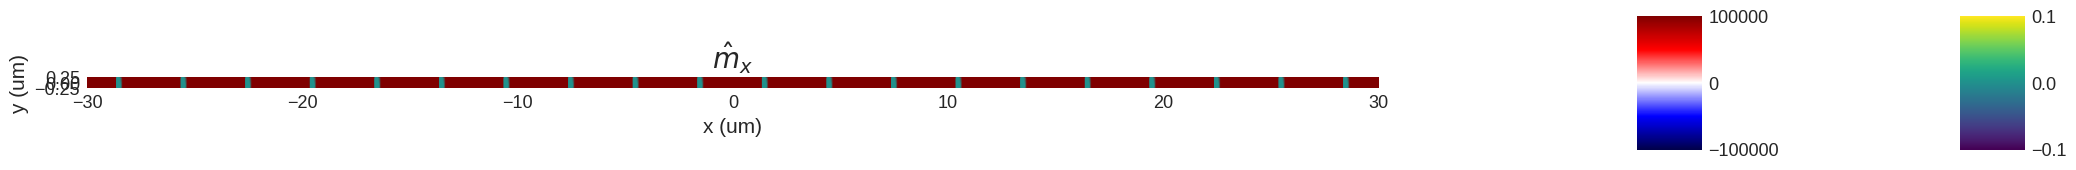

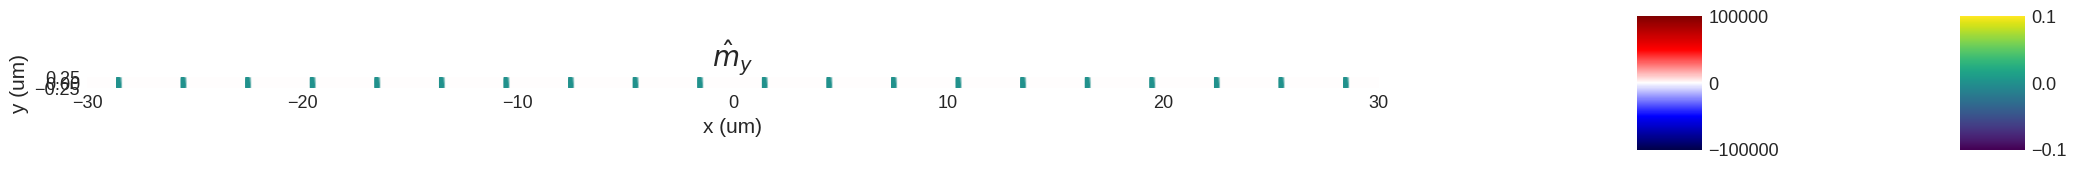

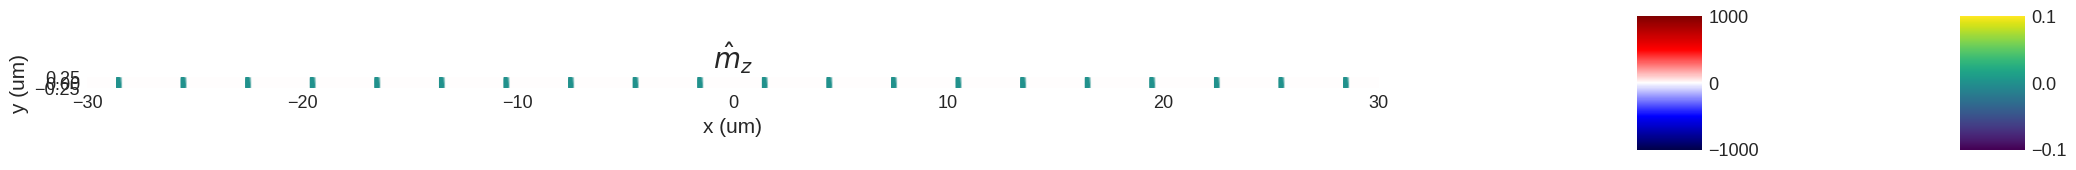

In [10]:
#WE ARE WORKING IN A 1D MESH, so we will not see any magnetization along y regardless unelss we make the mesh 2D


fig_x,ax_x =plt.subplots(figsize=(25,10))

plt.title('$\hat m_x$')
system.m.x.sel('z').mpl.scalar(ax=ax_x,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
system.m.sel('z').resample((20,10)).mpl.vector(ax=ax_x,headwidth=3,scale=2e7)

fig_y,ax_y =plt.subplots(figsize=(25,10))
plt.title('$\hat m_y$')
system.m.y.sel('z').mpl.scalar(ax=ax_y,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
system.m.sel('z').resample((20,10)).mpl.vector(ax=ax_y,headwidth=3,scale=2e7)

fig_z,ax_z =plt.subplots(figsize=(25,10))
plt.title('$\hat m_z$')
system.m.z.sel('z').mpl.scalar(ax=ax_z,vmin=-1000,vmax=1000,cmap='seismic')
system.m.sel('z').resample((20,10)).mpl.vector(ax=ax_z,headwidth=3,scale=2e7)




## Drive to equilibrium state

In [11]:
# get system to equilibrium
system.energy = dem + ex + zem +zem_transverse
mn.drive(system)

damping = mm.Damping(alpha=alpha)
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + damping

Running OOMMF (ExeOOMMFRunner)[2024/01/29 15:35]... (0.7 s)


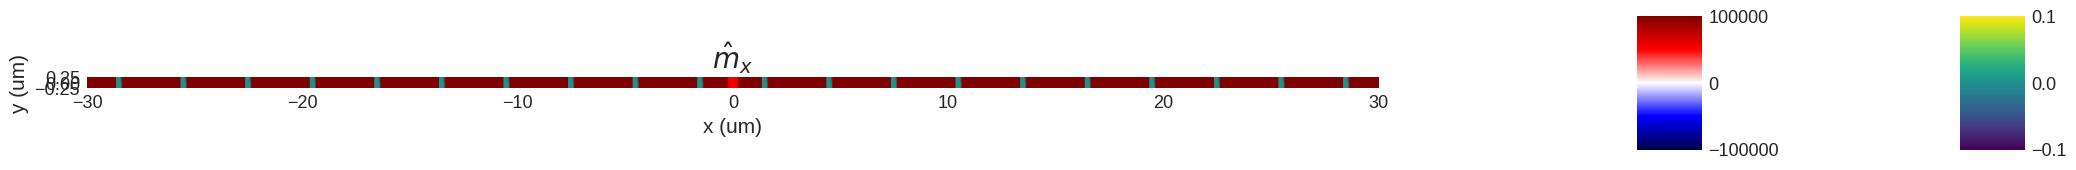

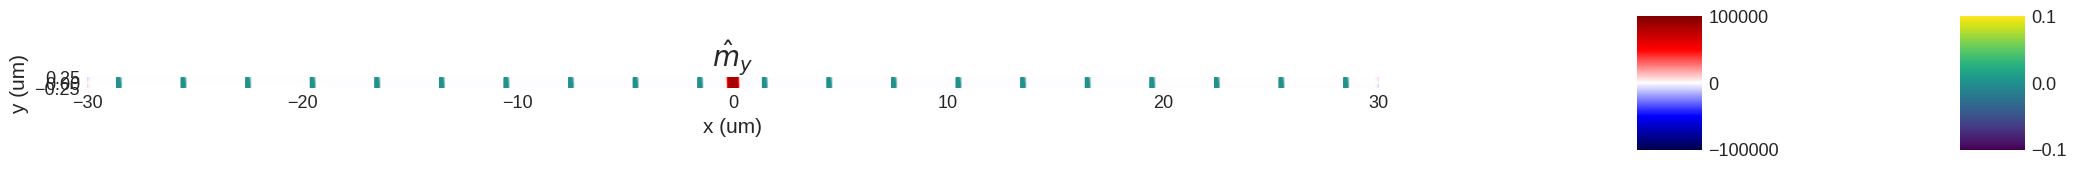

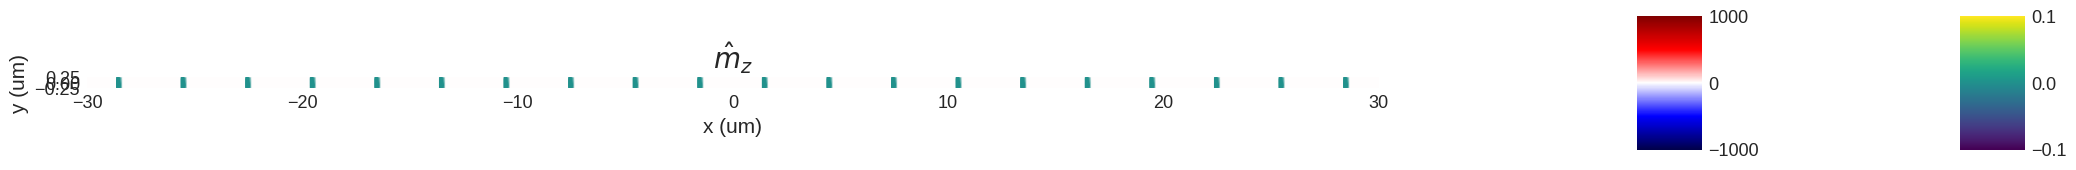

In [12]:
fig_x,ax_x =plt.subplots(figsize=(25,10))

plt.title('$\hat m_x$')
system.m.x.sel('z').mpl.scalar(ax=ax_x,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
system.m.sel('z').resample((20,10)).mpl.vector(ax=ax_x,headwidth=3,scale=2e7)

fig_y,ax_y =plt.subplots(figsize=(25,10))
plt.title('$\hat m_y$')
system.m.y.sel('z').mpl.scalar(ax=ax_y,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
system.m.sel('z').resample((20,10)).mpl.vector(ax=ax_y,headwidth=3,scale=2e7)

fig_z,ax_z =plt.subplots(figsize=(25,10))
plt.title('$\hat m_z$')
system.m.z.sel('z').mpl.scalar(ax=ax_z,vmin=-1000,vmax=1000,cmap='seismic')
system.m.sel('z').resample((20,10)).mpl.vector(ax=ax_z,headwidth=3,scale=2e7)




## RF injection

In [14]:
def Hspace_RF(point):
    x, y, z = point
    if (sourcePos-sourceWidth/2< x < sourcePos+sourceWidth/2 and -w/2 < y < w/2 and 0 < z < t):
        return (0, 0, H_RF_val)
    else:
        return (0,0,0)



H_RF = df.Field(mesh, nvdim=3, value=Hspace_RF)
zemRF = mm.Zeeman(H=H_RF, func=ftype, f=f_MAX, t0=T/sampling, name='RF')
try:
    system.energy += zemRF
finally:
    td.drive(system, t=T, n=sampling, n_threads=19, verbose=2)

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/650 files written [00:00]

Running OOMMF (ExeOOMMFRunner)[2024/01/29 15:51] took 4.2 s


KeyboardInterrupt: 

### Save simulation parameters in params.txt file

In [15]:
### Save simulation parameters in params.txt file
#import os
#cwd = os.getcwd()

with open(f"{sysName}/params.txt",'w') as f:
    if cy==w and cz==t:
        f.write(f"cell=({cx},w,t)\n")
    elif cy==w:
        f.write(f"cell=({cx},w,{cz})\n")
    elif cz==t:
        f.write(f"cell=({cx},{cy},t)\n")
    else:
        f.write(f"cell=({cx},{cy},{cz})")
    f.write("\n")
    f.write("Bias field:\n")
    f.write(f"Hx={Hx_0/Oe}Oe\n")
    f.write(f"Hy={Hz_0/Oe}Oe\n")
    f.write(f"Hz={Hz_0/Oe}Oe\n")
    f.write("\n")
    f.write("Barrier field:\n")
    f.write(f"H={Hy/Oe}Oe\n")
    f.write("\n")
    f.write("Exitation field:\n")
    f.write(f"Amplitude={H_RF_val}\n")
    f.write(f"f_MAX={f_MAX}\n")

## Time evolution before the "barrier"

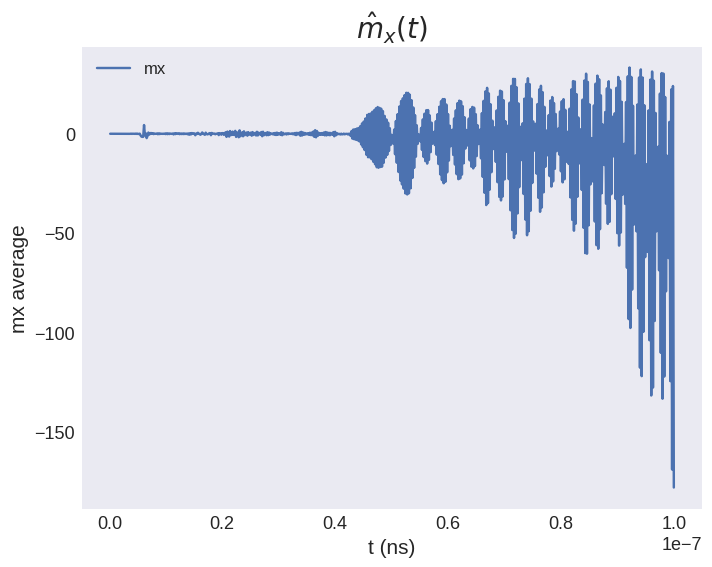

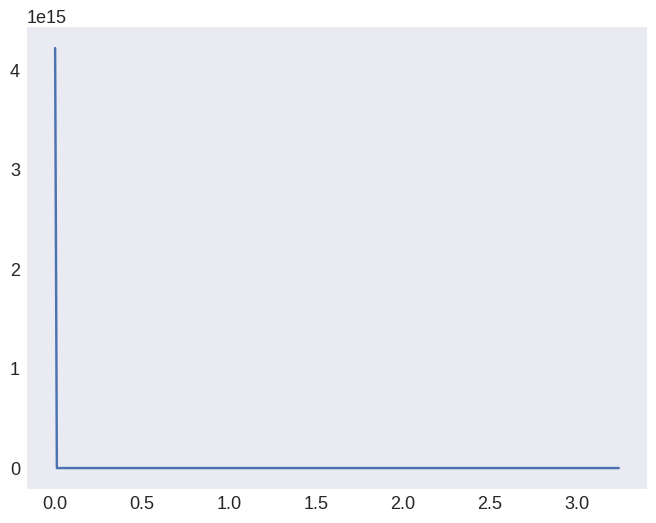

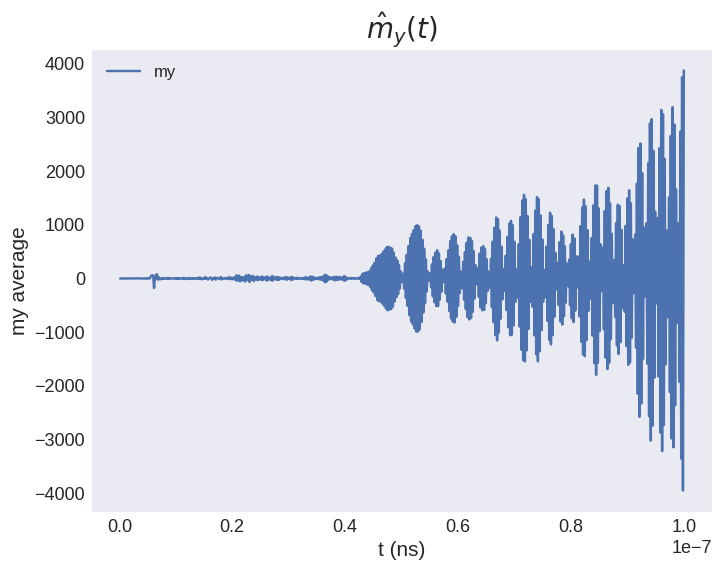

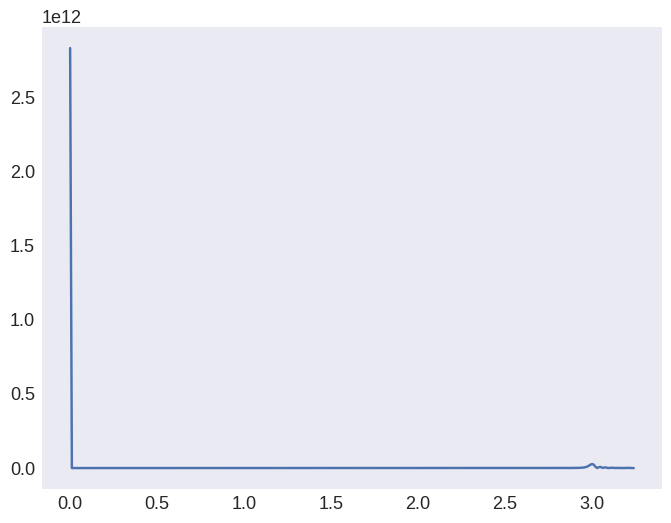

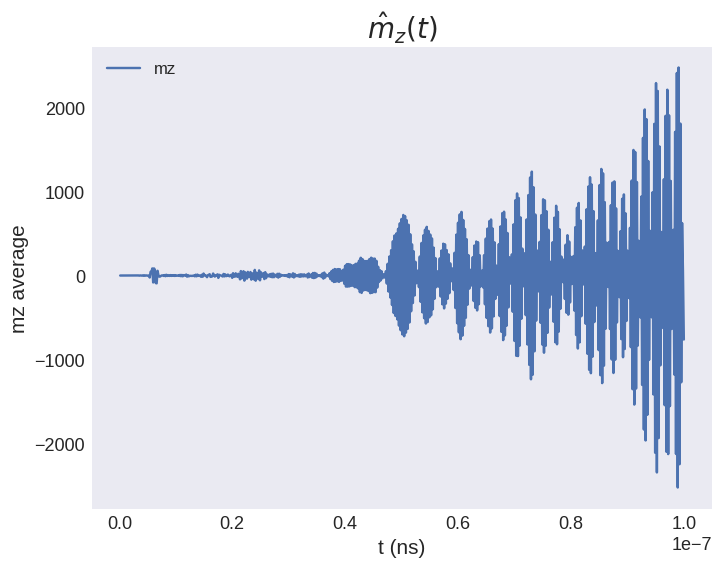

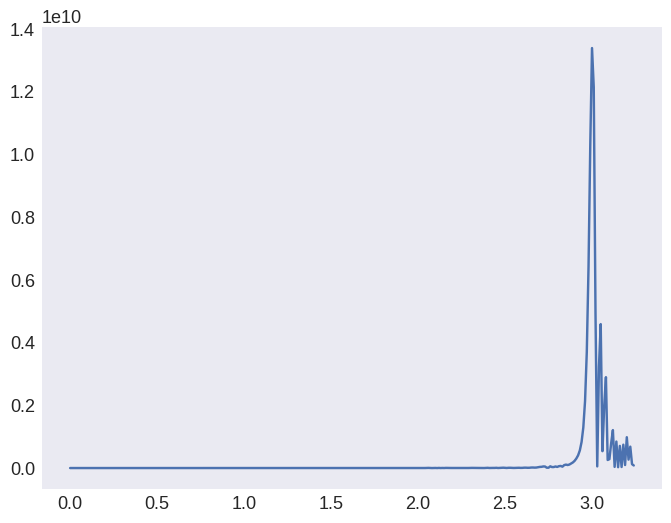

In [37]:
time=system.table.data["t"].values #.values returns a numpy array-> FFT
mz=system.table.data["mz"].values
my=system.table.data["my"].values


data=md.Data(sysName) #this contains all the drives up to now. [-1] means the last drive. Check the folder "Py_disk_FMR"
array=data[-1].to_xarray()
#print(len(list(data)))
mz1=[]
mx1=[]
my1=[]

for i in range(sampling):
    value_z=array[i, int((l/2-transverseFieldSize/2-2*buffer)/cx), int(w/2/cy), 0][2]
    value_x=array[i, int((l/2-transverseFieldSize/2-2*buffer)/cx), int(w/2/cy), 0][0]
    value_y=array[i, int((l/2-transverseFieldSize/2-2*buffer)/cx), int(w/2/cy), 0][1]

    """the above means:
    -we take the value of the magnetization at the i-th sampling operation
    -at position mesh[int(r/cx),int(r/cy),0]
    -along the z axis (x=0, y=1, z=2) 
    note that mz is the global magnetization average, so we have smaller oscillations, while mz1 is the LOCAL magnetization
    """
    mz1.append(value_z)
    mx1.append(value_x)
    my1.append(value_y)




#mx(t)
plt.figure()
plt.title('$\hat m_x(t)$')
plt.plot(time,[i-mx1[0] for i in mx1])
plt.xlabel('t (ns)')
plt.ylabel('mx average')
plt.legend(['mx'])
plt.show()
amp=np.abs(np.fft.fft(mx1))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])


#my(t)
plt.figure()
plt.title('$\hat m_y(t)$')
plt.plot(time,[i-my1[0] for i in my1])
plt.xlabel('t (ns)')
plt.ylabel('my average')
plt.legend(['my'])
plt.show()
amp=np.abs(np.fft.fft(my1))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])

#mz
plt.figure()
plt.title('$\hat m_z(t)$')
plt.plot(time,mz1)
plt.xlabel('t (ns)')
plt.ylabel('mz average')
plt.legend(['mz'])
plt.show()
amp=np.abs(np.fft.fft(mz1))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])


## Time evolution inside the "barrier"

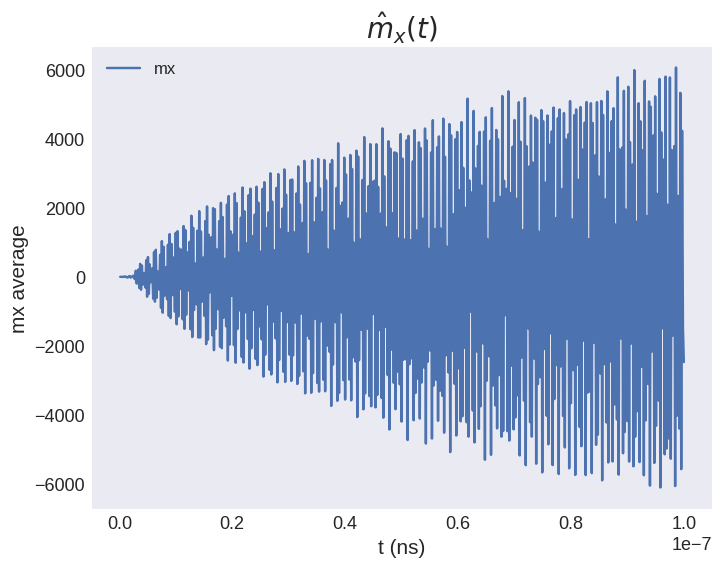

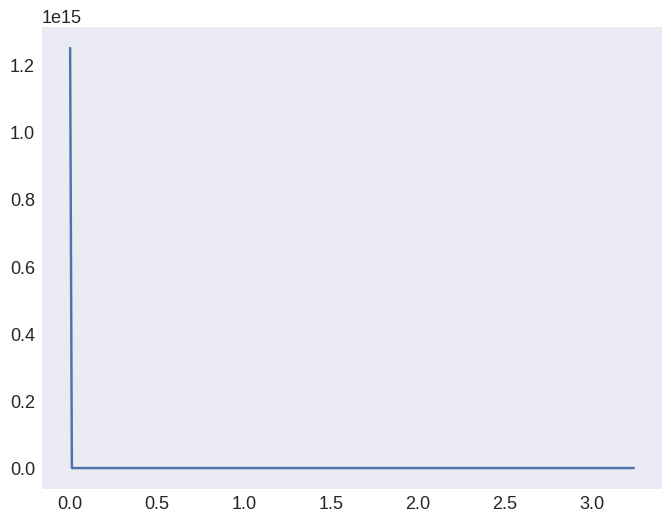

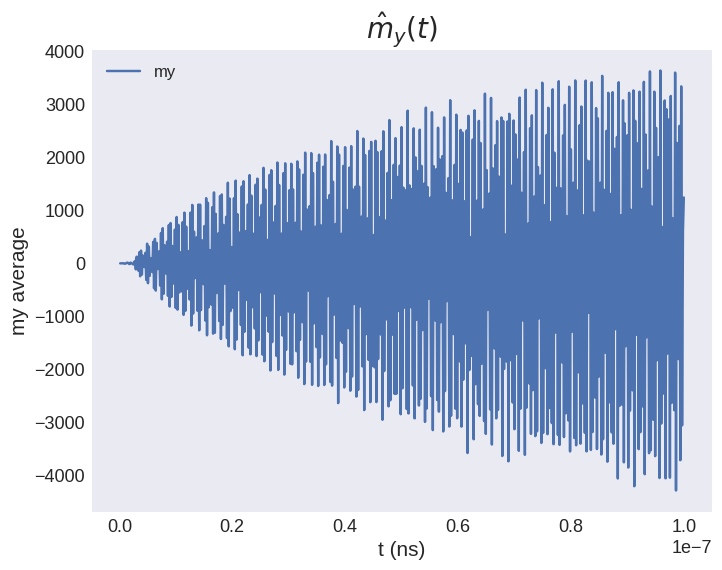

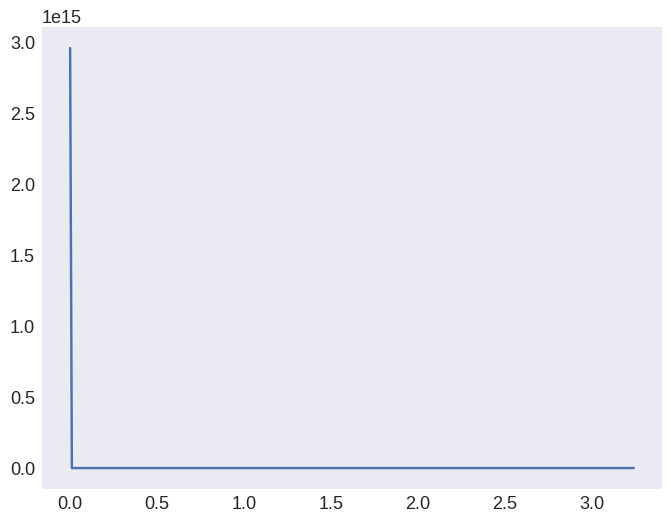

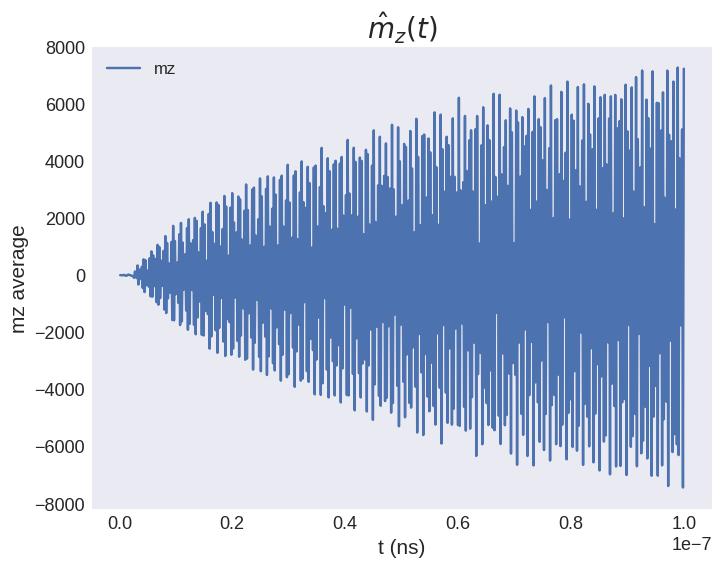

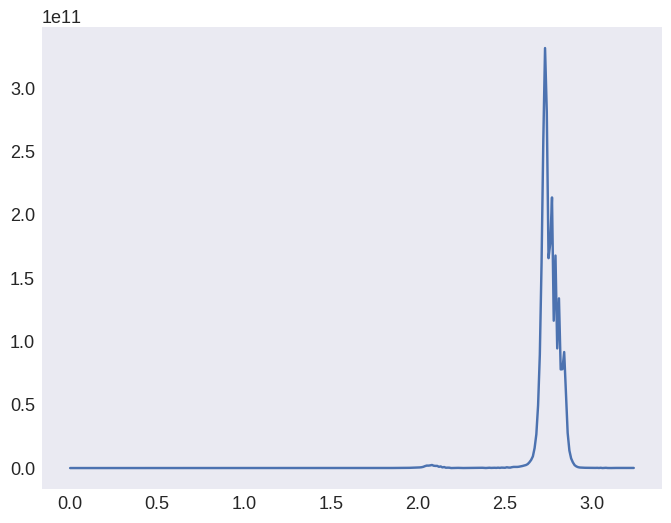

In [38]:
time=system.table.data["t"].values #.values returns a numpy array-> FFT
mz=system.table.data["mz"].values
my=system.table.data["my"].values


data=md.Data(sysName) #this contains all the drives up to now. [-1] means the last drive. Check the folder "Py_disk_FMR"
array=data[-1].to_xarray()
#print(len(list(data)))
mz1=[]
mx1=[]
my1=[]

for i in range(sampling):
    value_z=array[i, int((l/2)/cx), int(w/2/cy), 0][2]
    value_x=array[i, int((l/2)/cx), int(w/2/cy), 0][0]
    value_y=array[i, int((l/2)/cx), int(w/2/cy), 0][1]

    """the above means:
    -we take the value of the magnetization at the i-th sampling operation
    -at position mesh[int(r/cx),int(r/cy),0]
    -along the z axis (x=0, y=1, z=2) 
    note that mz is the global magnetization average, so we have smaller oscillations, while mz1 is the LOCAL magnetization
    """
    mz1.append(value_z)
    mx1.append(value_x)
    my1.append(value_y)





#mx(t)
plt.figure()
plt.title('$\hat m_x(t)$')
plt.plot(time,[i-mx1[0] for i in mx1])
plt.xlabel('t (ns)')
plt.ylabel('mx average')
plt.legend(['mx'])
plt.show()
amp=np.abs(np.fft.fft(mx1))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])


#my(t)
plt.figure()
plt.title('$\hat m_y(t)$')
plt.plot(time,[i-my1[0] for i in my1])
plt.xlabel('t (ns)')
plt.ylabel('my average')
plt.legend(['my'])
plt.show()
amp=np.abs(np.fft.fft(my1))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])

#mz
plt.figure()
plt.title('$\hat m_z(t)$')
plt.plot(time,mz1)
plt.xlabel('t (ns)')
plt.ylabel('mz average')
plt.legend(['mz'])
plt.show()
amp=np.abs(np.fft.fft(mz1))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])



## Time evolution after the barrier

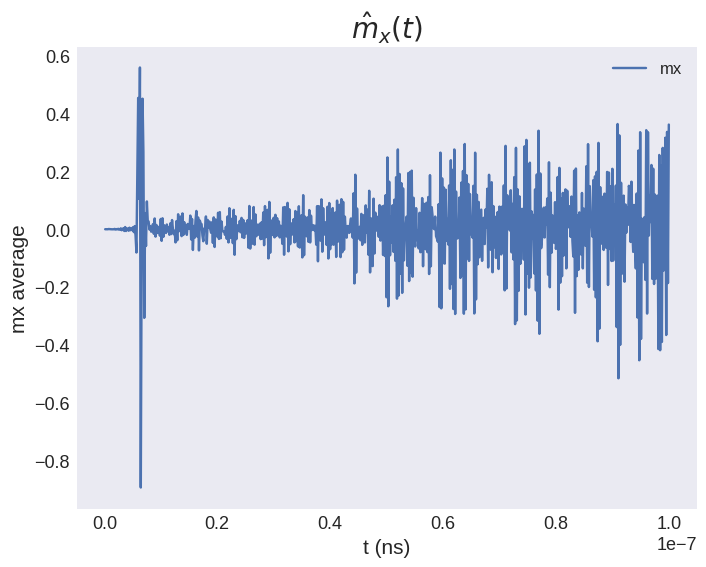

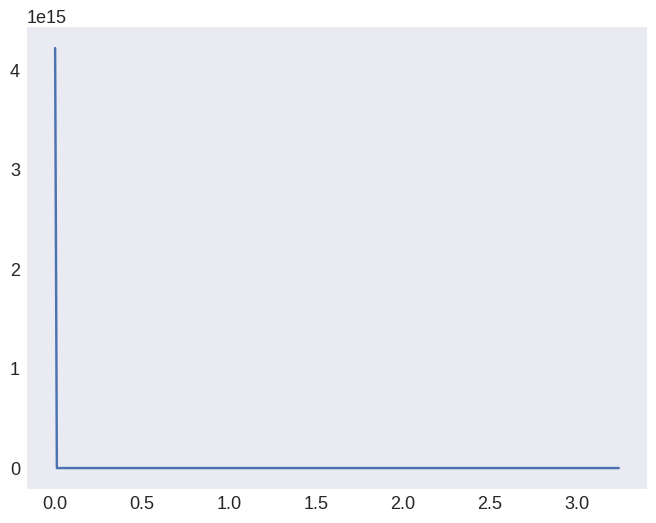

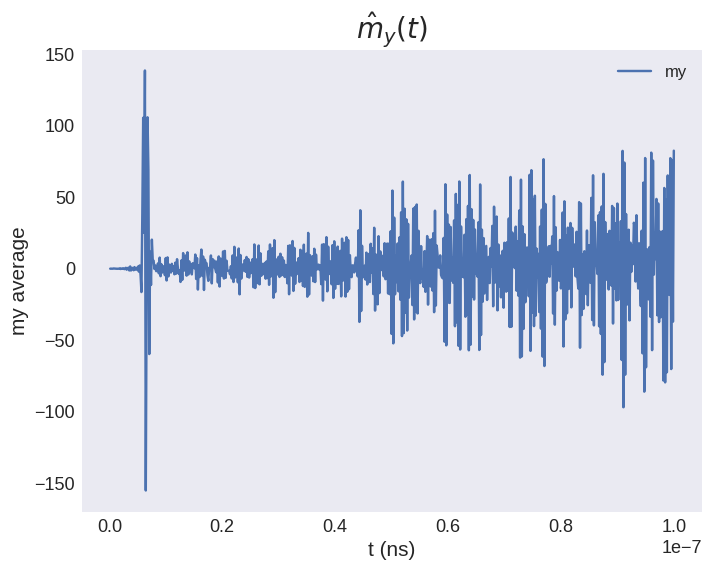

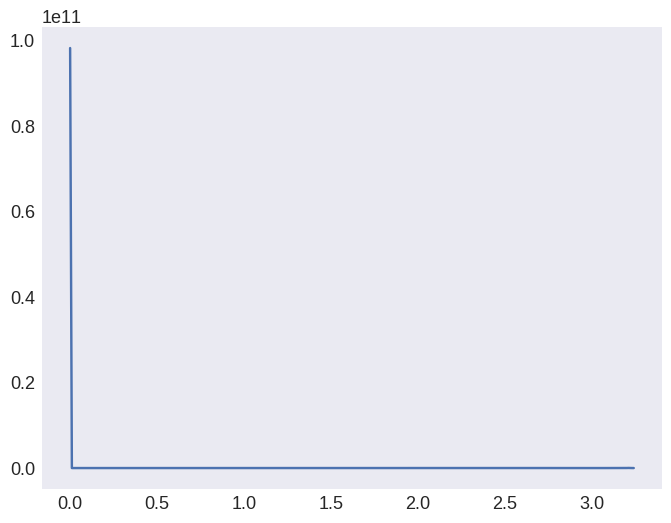

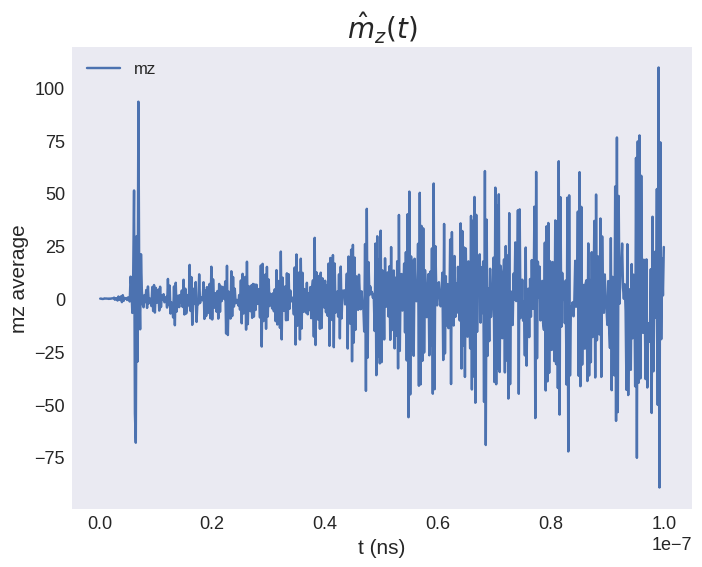

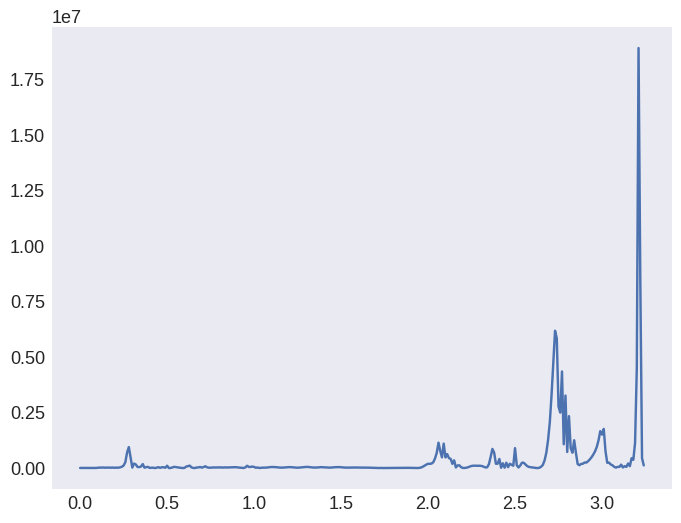

In [39]:
time=system.table.data["t"].values #.values returns a numpy array-> FFT
mz=system.table.data["mz"].values
my=system.table.data["my"].values


data=md.Data(sysName) #this contains all the drives up to now. [-1] means the last drive. Check the folder "Py_disk_FMR"
array=data[-1].to_xarray()
#print(len(list(data)))
mz1=[]
mx1=[]
my1=[]

for i in range(sampling):
    value_z=array[i, int((l/2+transverseFieldSize/2+2*buffer)/cx), int(w/2/cy), 0][2]
    value_x=array[i, int((l/2+transverseFieldSize/2+2*buffer)/cx), int(w/2/cy), 0][0]
    value_y=array[i, int((l/2+transverseFieldSize/2+2*buffer)/cx), int(w/2/cy), 0][1]

    """the above means:
    -we take the value of the magnetization at the i-th sampling operation
    -at position mesh[int(r/cx),int(r/cy),0]
    -along the z axis (x=0, y=1, z=2) 
    note that mz is the global magnetization average, so we have smaller oscillations, while mz1 is the LOCAL magnetization
    """
    mz1.append(value_z)
    mx1.append(value_x)
    my1.append(value_y)


#mx(t)
plt.figure()
plt.title('$\hat m_x(t)$')
plt.plot(time,[i-mx1[0] for i in mx1])
plt.xlabel('t (ns)')
plt.ylabel('mx average')
plt.legend(['mx'])
plt.show()
amp=np.abs(np.fft.fft(mx1))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])


#my(t)
plt.figure()
plt.title('$\hat m_y(t)$')
plt.plot(time,[i-my1[0] for i in my1])
plt.xlabel('t (ns)')
plt.ylabel('my average')
plt.legend(['my'])
plt.show()
amp=np.abs(np.fft.fft(my1))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])

#mz
plt.figure()
plt.title('$\hat m_z(t)$')
plt.plot(time,mz1)
plt.xlabel('t (ns)')
plt.ylabel('mz average')
plt.legend(['mz'])
plt.show()
amp=np.abs(np.fft.fft(mz1))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])
